## Step 1: Dependencies

Install all the Huggingface python packages

In [1]:
%%capture
!pip install git+https://github.com/huggingface/diffusers.git
!pip install accelerate
!pip install datasets
!pip install bitsandbytes

Define a simple function to plot a list of images returned from the model when generating

In [16]:
def plot_images(images, labels=None):
    from matplotlib import pyplot as plt
    plt.figure()
    f, axarr = plt.subplots(1, len(images), figsize=(40,10))
    if labels is not None:
      assert len(images) == len(labels) , "Images and labels must have the same length"
      i = 0

    for ax, img in zip(axarr.flatten(), images):
        ax.imshow(img)
        if labels is not None:
          ax.set_title(labels[i])
          i += 1
        ax.axis('off')
    plt.show()

Import the relevant python libraries to load and sample from the Stable Diffusion model

In [3]:
import os
import torch

from diffusers import StableDiffusionPipeline
from diffusers import DiffusionPipeline

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [4]:
import gc
gc.collect()
torch.cuda.empty_cache()

## Step 2: Fine-tune the model

Let's clone the dataset from and the hugging face

In [5]:
!git clone https://huggingface.co/datasets/nadavo11/ImSitu_reduced

Cloning into 'ImSitu_reduced'...
remote: Enumerating objects: 478, done.
remote: Counting objects: 100% (475/475), done.
remote: Compressing objects: 100% (475/475), done.
remote: Total 478 (delta 226), reused 0 (delta 0), pack-reused 3 (from 1)
Receiving objects: 100% (478/478), 2.11 MiB | 3.44 MiB/s, done.
Resolving deltas: 100% (226/226), done.
Filtering content: 100% (4/4), 1.60 GiB | 43.32 MiB/s, done.


and then clone the dataset and the hugging face code which contains the finetuning script

In [6]:
!git clone https://github.com/huggingface/diffusers.git

Cloning into 'diffusers'...
remote: Enumerating objects: 70946, done.
remote: Counting objects: 100% (513/513), done.
remote: Compressing objects: 100% (263/263), done.
remote: Total 70946 (delta 315), reused 345 (delta 207), pack-reused 70433 (from 1)
Receiving objects: 100% (70946/70946), 50.01 MiB | 21.51 MiB/s, done.
Resolving deltas: 100% (52400/52400), done.


Set some flags for the finetuning script, the dataset to be used and the number of iterations. Since the dataset we chose is small and we want to finetune quickly using the colab free tier, let's only finetune for 50 epochs

# sample from the dataset


In [ ]:
path_to_dataset = '/content/ImSitu_reduced'
imgs = os.listdir(path_to_dataset)
from PIL import Image
import matplotlib.pyplot as plt
import os

from datasets import load_dataset

# Load the dataset from Hugging Face
dataset = load_dataset("nadavo11/ImSitu_reduced")

# View a sample of the dataset
print(dataset)



<Figure size 640x480 with 0 Axes>

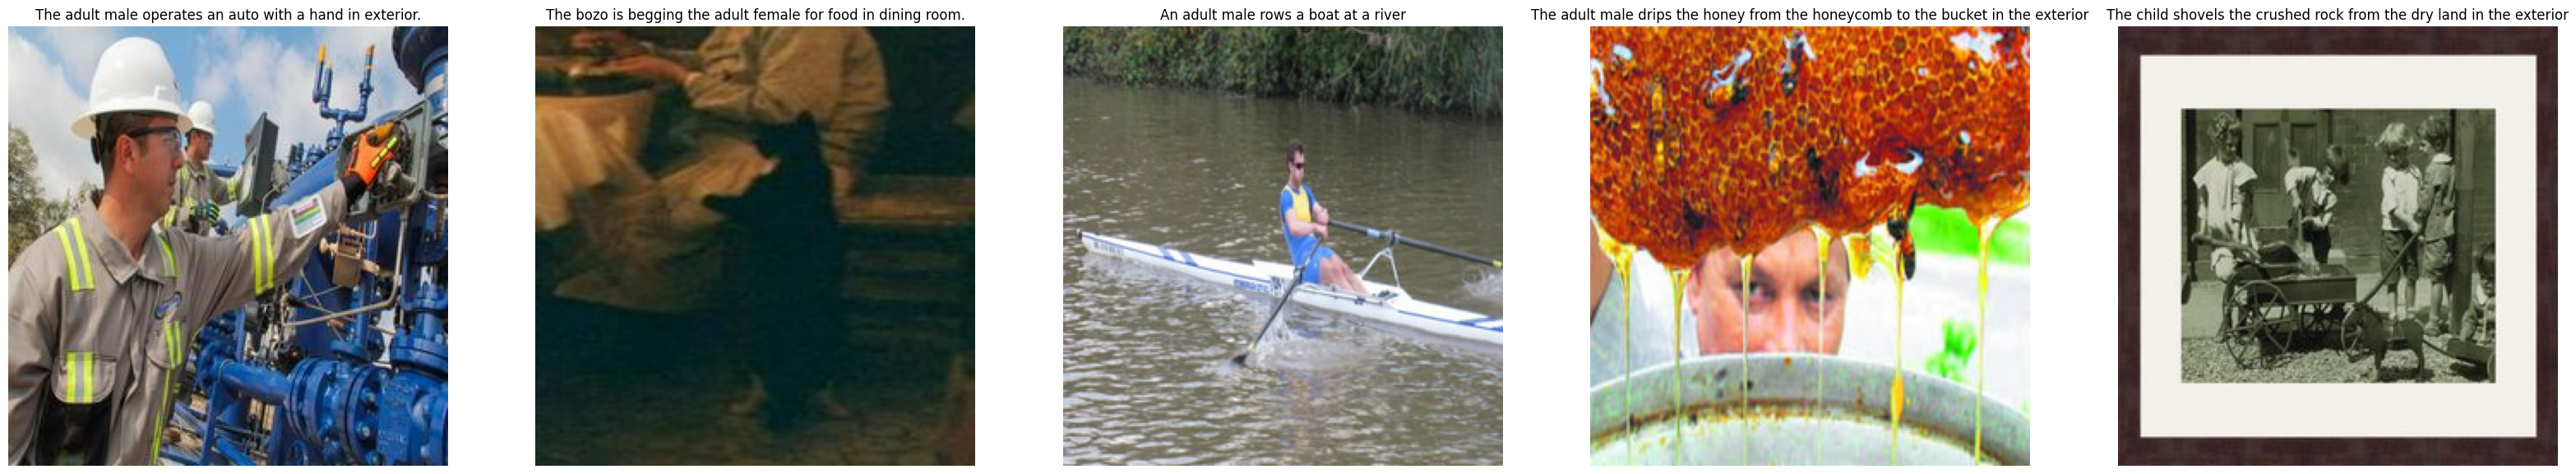

In [17]:
# Access the first image in the dataset
images = dataset["train"][:5]["file_name"]
labels = dataset["train"][:5]["text"]
# If the image is stored as a path, you can load it using PIL

plot_images(images,labels)
# for i, img_file in enumerate(image_files):
#     img_path = os.path.join(image_folder, img_file)

#     try:
#         img = Image.open(img_path)
#         axes[i].imshow(img)
#         axes[i].set_title(img_file)
#         axes[i].axis('off')
#     except Exception as e:
#         axes[i].text(0.5, 0.5, 'Image not found', horizontalalignment='center', verticalalignment='center')
#         axes[i].set_title(img_file)
#         axes[i].axis('off')

# plt.show()

Now we run the actual fine-tuning script. **IMPORTANT:** Remember if you want to train on google's free T4 GPU it's crucial to add the flag

```
--use_8bit_adam
```
We will save the model in the *city-building-model* folder


In [19]:
DATASET_NAME = 'ImSitu_reduced' #@param {'type':'string'}
MODEL_NAME = 'stabilityai/stable-diffusion-2-1-base' #@param {'type':'string'}
MAX_TRAINING_EPOCHS = 1 #@param {'type':'integer'}
MODEL_TARGET_FOLDER = 'ImSitu_reduced_model' #@param {'type':'string'}

In [21]:
# del pipe
# del images

# delete the reverse_text column in the dataset
dataset = dataset.remove_columns(['reverse_text'])

In [24]:
# The --use_8bit_adam flag is crucial to be able to train on the T4 GPU which has only 15GB of memory
!accelerate launch diffusers/examples/text_to_image/train_text_to_image.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --dataset_name=$DATASET_NAME \
  --use_ema \
  --use_8bit_adam \
  --resolution=512 --center_crop --random_flip \
  --train_batch_size=1 \
  --gradient_accumulation_steps=4 \
  --gradient_checkpointing \
  --mixed_precision="fp16" \
  --max_train_steps=$MAX_TRAINING_EPOCHS \
  --learning_rate=1e-05 \
  --max_grad_norm=1 \
  --image_column="file_name" \
  --lr_scheduler="constant" --lr_warmup_steps=0 \
  --output_dir=$MODEL_TARGET_FOLDER

The following values were not passed to `accelerate launch` and had defaults used instead:
	`--num_processes` was set to a value of `1`
	`--num_machines` was set to a value of `1`
	`--mixed_precision` was set to a value of `'no'`
	`--dynamo_backend` was set to a value of `'no'`
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
2024-09-20 13:38:21.656757: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-20 13:38:21.676190: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-20 13:38:21.681974: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has alread

## Step 3: Sample from the finetuned model

We load the new model in the GPU (this time we don't need to Download anything as the fine-tuned model has been saved locally) and generate some more images

In [ ]:
pipe = StableDiffusionPipeline.from_pretrained(MODEL_TARGET_FOLDER, torch_dtype=torch.float16)
pipe = pipe.to("cuda")


In [ ]:

prompt = "the dog is kissing the person" # @param {"type":"string"}
negative_prompt = "deformed face, ugly face, two heads " # @param {"type":"string"}
inference_steps = 40 # @param {"type":"integer"}
num_images = 5 # @param {"type":"integer"}
guidance_scale = 9 # @param {"type":"number"}
images = pipe(prompt,
              negative_prompt=negative_prompt,
              num_inference_steps = inference_steps,
              guidance_scale = guidance_scale,
              num_images_per_prompt=num_images,

              ).images

In [ ]:
plot_images(images)

In [ ]:
prompt = "the person is kissing the dog" # @param {"type":"string"}
negative_prompt = "deformed face, ugly face, two heads " # @param {"type":"string"}
inference_steps = 40 # @param {"type":"integer"}
num_images = 5 # @param {"type":"integer"}
guidance_scale = 9 # @param {"type":"number"}
images = pipe(prompt,
              negative_prompt=negative_prompt,
              num_inference_steps = inference_steps,
              guidance_scale = guidance_scale,
              num_images_per_prompt=num_images,

              ).images

In [ ]:
plot_images(images)

In [ ]:
del pipe
del images

NameError: name 'pipe' is not defined

In [ ]:

# see the difference from base model
pipe = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2-1-base", torch_dtype=torch.float16)
pipe = pipe.to("cuda")

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:

prompt = "the dog is kissing the person" # @param {"type":"string"}
negative_prompt = "deformed face, ugly face, two heads " # @param {"type":"string"}
inference_steps = 40 # @param {"type":"integer"}
num_images = 5 # @param {"type":"integer"}
guidance_scale = 9 # @param {"type":"number"}
images = pipe(prompt,
              negative_prompt=negative_prompt,
              num_inference_steps = inference_steps,
              guidance_scale = guidance_scale,
              num_images_per_prompt=num_images,

              ).images

  0%|          | 0/40 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

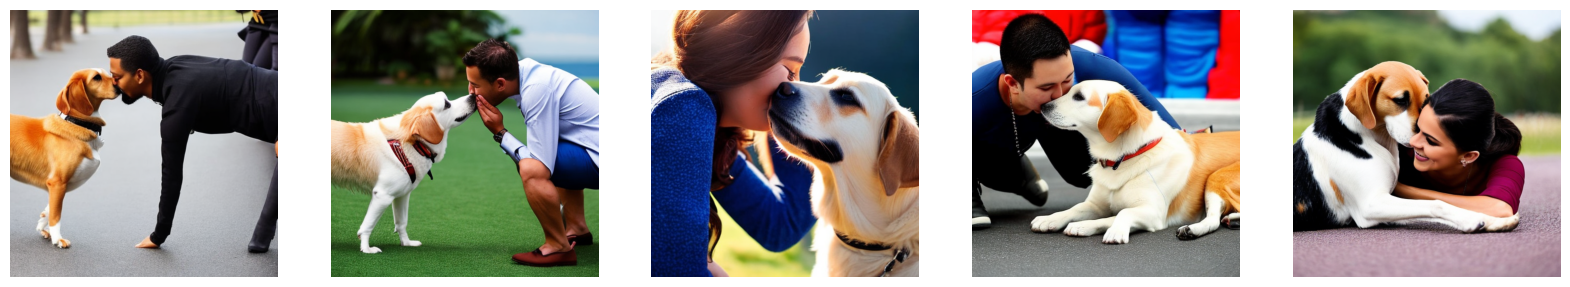

In [ ]:
plot_images(images)

In [ ]:

prompt = "the person is kissing the dog" # @param {"type":"string"}
negative_prompt = "deformed face, ugly face, two heads " # @param {"type":"string"}
inference_steps = 40 # @param {"type":"integer"}
num_images = 5 # @param {"type":"integer"}
guidance_scale = 9 # @param {"type":"number"}
images = pipe(prompt,
              negative_prompt=negative_prompt,
              num_inference_steps = inference_steps,
              guidance_scale = guidance_scale,
              num_images_per_prompt=num_images,

              ).images

  0%|          | 0/40 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

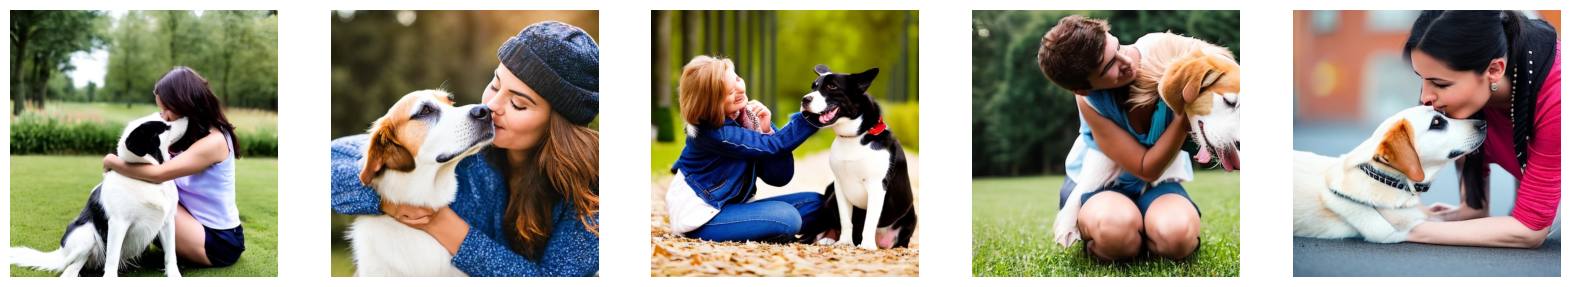

In [ ]:
plot_images(images)